<a href="https://colab.research.google.com/github/Kalisa21/SmartCiti/blob/main/TrafficSense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Importing libraries

In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

2. Data loading

In [83]:
# Load Dataset
df = pd.read_csv("/content/Traffic.csv")

3. Inspect the data

In [84]:
# add the data to be able to do the EDS
df = pd.read_csv('/content/Traffic.csv')

# print out the first head of the data
df.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal


In [85]:
# Check for the data types of each column
print("\nData types of each column:")
print(df.dtypes)


Data types of each column:
Time                 object
Date                  int64
Day of the week      object
CarCount              int64
BikeCount             int64
BusCount              int64
TruckCount            int64
Total                 int64
Traffic Situation    object
dtype: object


In [86]:
# get a summary of the data set
print("\nSummary of the dataset:")
print(df.info())


Summary of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               2976 non-null   object
 1   Date               2976 non-null   int64 
 2   Day of the week    2976 non-null   object
 3   CarCount           2976 non-null   int64 
 4   BikeCount          2976 non-null   int64 
 5   BusCount           2976 non-null   int64 
 6   TruckCount         2976 non-null   int64 
 7   Total              2976 non-null   int64 
 8   Traffic Situation  2976 non-null   object
dtypes: int64(6), object(3)
memory usage: 209.4+ KB
None


In [87]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# drop all the missing values
df = df.dropna()


Missing values in each column:
Time                 0
Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
dtype: int64


4. Data preprocessing

In [88]:
# Data Preprocessing
def preprocess_data(df, fit_scaler=True, scaler=None, label_encoder=None, is_prediction=False):
    """Preprocess the dataset: feature engineering, encoding, scaling."""
    df_processed = df.copy()

    if not is_prediction:
        df_processed['Hour'] = pd.to_datetime(df_processed['Time'], format='%I:%M:%S %p').dt.hour
        df_processed = df_processed.drop(columns=['Time', 'Date'])

    # Feature engineering
    if 'Vehicle_Density' not in df_processed.columns:
        df_processed['Vehicle_Density'] = df_processed['Total'] / 4
    if 'Heavy_Vehicle_Ratio' not in df_processed.columns:
        df_processed['Heavy_Vehicle_Ratio'] = (df_processed['BusCount'] + df_processed['TruckCount']) / df_processed['Total'].replace(0, 1)

    # Convert 'Day of the week' to numerical values
    if not is_prediction and df_processed['Day of the week'].dtype == 'object':
        day_mapping = {
            'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
            'Friday': 4, 'Saturday': 5, 'Sunday': 6
        }
        df_processed['Day of the week'] = df_processed['Day of the week'].map(day_mapping)

    if not is_prediction:
        if label_encoder is None:
            label_encoder = LabelEncoder()
            df_processed['Traffic Situation'] = label_encoder.fit_transform(df_processed['Traffic Situation'])
        else:
            df_processed['Traffic Situation'] = label_encoder.transform(df_processed['Traffic Situation'])
        X = df_processed.drop(columns=['Traffic Situation'])
        y = df_processed['Traffic Situation']
    else:
        X = df_processed
        y = None

    if fit_scaler:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)

    return X_scaled, y, scaler, label_encoder

5. Data visualization

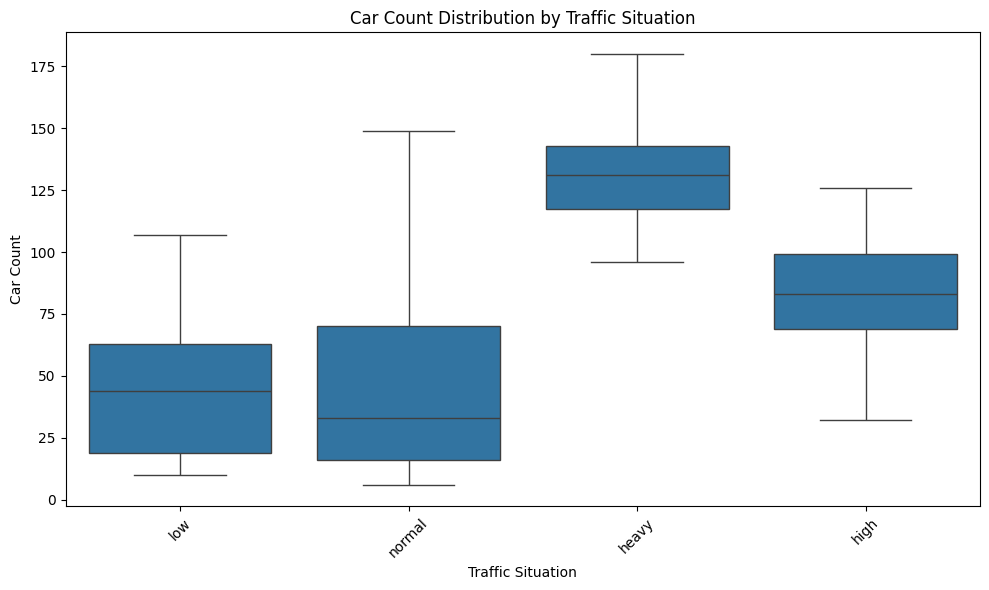

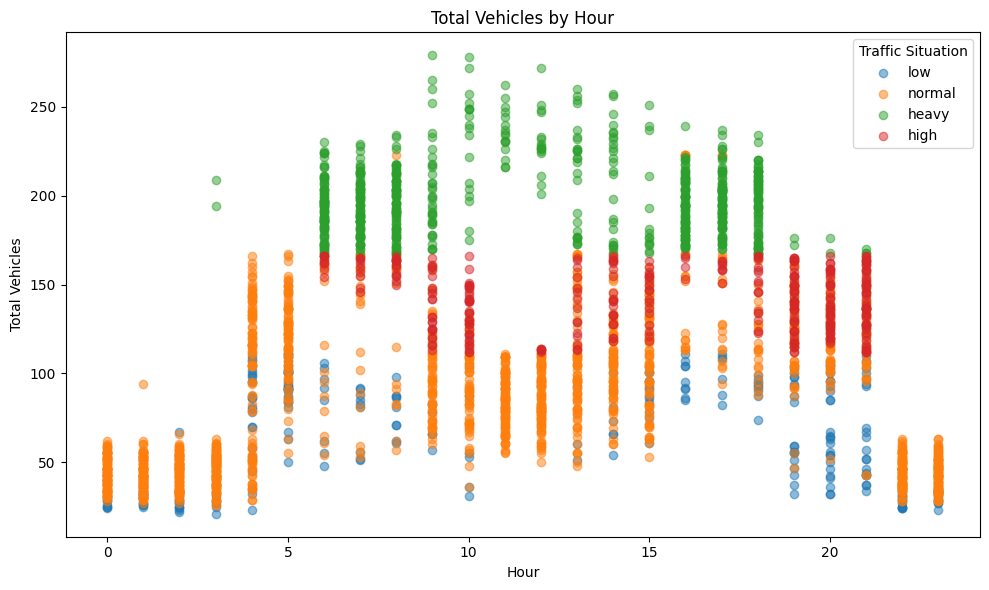

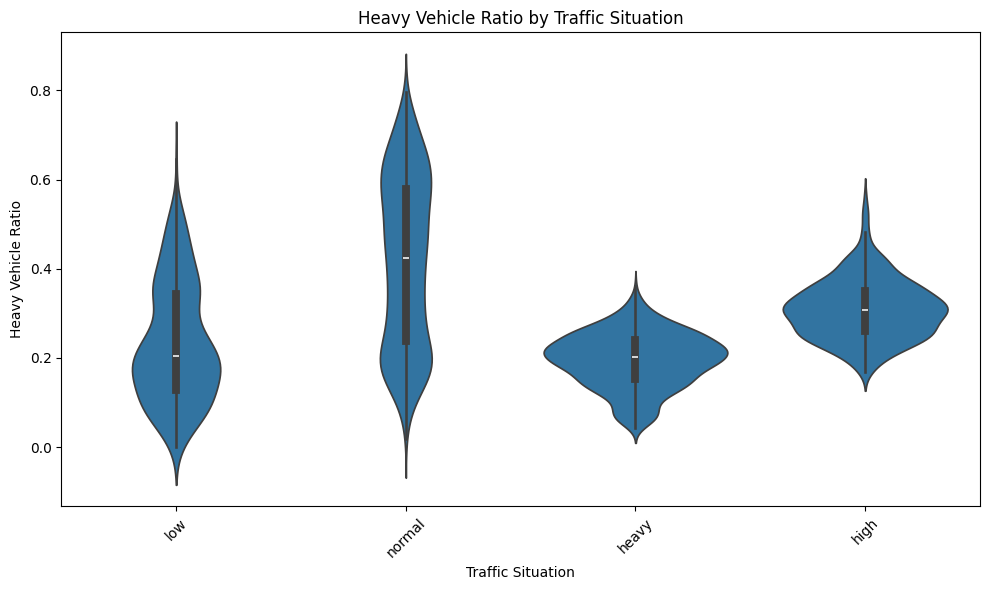

In [89]:
# Data Visualization with Matplotlib
def create_visualizations(df):
    df['Hour'] = pd.to_datetime(df['Time'], format='%I:%M:%S %p').dt.hour

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Traffic Situation', y='CarCount', data=df)
    plt.title('Car Count Distribution by Traffic Situation')
    plt.xlabel('Traffic Situation')
    plt.ylabel('Car Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    for situation in df['Traffic Situation'].unique():
        subset = df[df['Traffic Situation'] == situation]
        plt.scatter(subset['Hour'], subset['Total'], label=situation, alpha=0.5)
    plt.title('Total Vehicles by Hour')
    plt.xlabel('Hour')
    plt.ylabel('Total Vehicles')
    plt.legend(title='Traffic Situation')
    plt.tight_layout()
    plt.show()

    df['Heavy_Vehicle_Ratio'] = (df['BusCount'] + df['TruckCount']) / df['Total'].replace(0, 1)
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Traffic Situation', y='Heavy_Vehicle_Ratio', data=df)
    plt.title('Heavy Vehicle Ratio by Traffic Situation')
    plt.xlabel('Traffic Situation')
    plt.ylabel('Heavy Vehicle Ratio')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

create_visualizations(df)


6. Model training

In [90]:
# Model Training
def train_model(X_train, y_train, X_val, y_val, pretrained_model_path=None):
    if pretrained_model_path:
        model = tf.keras.models.load_model(pretrained_model_path)
    else:
        model = Sequential([
            Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
            Dropout(0.3),
            Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
            Dropout(0.3),
            Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
            Dense(4, activation='softmax')
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1)

    return model, history

7. Model evaluation

In [91]:
# Model Evaluation
def evaluate_model(model, X_test, y_test, label_encoder, title="Confusion Matrix"):
    y_pred = model.predict(X_test).argmax(axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"\nEvaluation Metrics for {title}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()


8. Prediction script

In [92]:
def predict_traffic(model, scaler, label_encoder, input_data):
    total = input_data['CarCount'] + input_data['BikeCount'] + input_data['BusCount'] + input_data['TruckCount']
    vehicle_density = total / 4
    heavy_vehicle_ratio = (input_data['BusCount'] + input_data['TruckCount']) / total if total > 0 else 0
    input_df = pd.DataFrame([{
        'CarCount': input_data['CarCount'],
        'BikeCount': input_data['BikeCount'],
        'BusCount': input_data['BusCount'],
        'TruckCount': input_data['TruckCount'],
        'Total': total,
        'Hour': input_data['Hour'],
        'Day of the week': input_data['Day of the week'],
        'Vehicle_Density': vehicle_density,
        'Heavy_Vehicle_Ratio': heavy_vehicle_ratio
    }])
    feature_order = scaler.feature_names_in_
    input_df = input_df[feature_order]
    X_scaled, _, _, _ = preprocess_data(input_df, fit_scaler=False, scaler=scaler, label_encoder=label_encoder, is_prediction=True)
    pred = model.predict(X_scaled).argmax(axis=1)
    return label_encoder.inverse_transform(pred)[0]

9. Main execution

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5524 - loss: 2.4175 - val_accuracy: 0.7429 - val_loss: 1.6593
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7385 - loss: 1.5748 - val_accuracy: 0.8151 - val_loss: 1.1882
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8187 - loss: 1.1289 - val_accuracy: 0.8874 - val_loss: 0.9131
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8865 - loss: 0.8694 - val_accuracy: 0.8824 - val_loss: 0.7555
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8727 - loss: 0.7313 - val_accuracy: 0.8773 - val_loss: 0.6694
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8812 - loss: 0.6445 - val_accuracy: 0.9042 - val_loss: 0.6016
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8856 - loss: 0.6237 - val_accuracy: 0.9059 - val_loss: 0.5581
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8890 - loss: 0.5536 - val_accuracy: 0.9059 - val_loss: 0.5

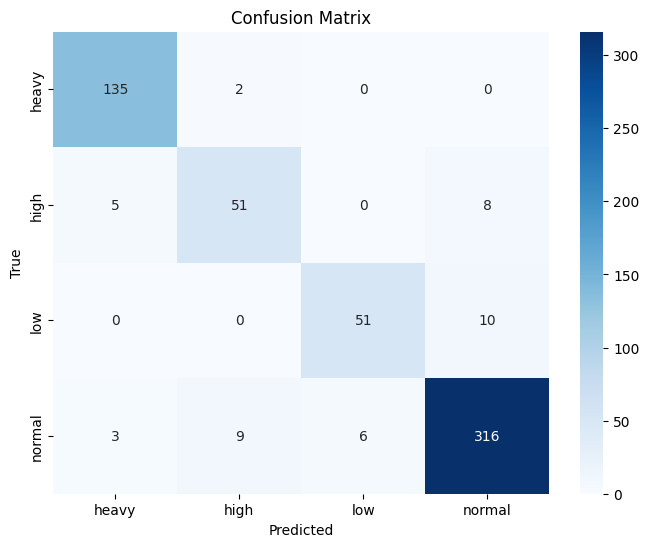

['label_encoder.pkl']

In [93]:
# Main Execution
X, y, scaler, label_encoder = preprocess_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)
model, history = train_model(X_train, y_train, X_val, y_val)
evaluate_model(model, X_test, y_test, label_encoder)
model.save('traffic_model.keras')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

 10. Interactive prediction input

In [94]:
# --- Interactive Prediction Input ---
print("\nEnter your traffic data for prediction:")
car_count   = int(input("CarCount: "))
bike_count  = int(input("BikeCount: "))
bus_count   = int(input("BusCount: "))
truck_count = int(input("TruckCount: "))
hour        = int(input("Hour (0-23): "))
day_of_week = int(input("Day of Week (0-6, where 0=Monday, 6=Sunday): "))

# Validate day of week input
if day_of_week not in range(0, 7):
    print("Invalid day of the week. Please enter a number between 0 and 6.")
else:
    input_data = {
        'CarCount': car_count,
        'BikeCount': bike_count,
        'BusCount': bus_count,
        'TruckCount': truck_count,
        'Hour': hour,
        'Day of the week': day_of_week
    }

    prediction = predict_traffic(model, scaler, label_encoder, input_data)
    print(f"\nPredicted Traffic Situation: {prediction}")


Enter your traffic data for prediction:
CarCount: 12
BikeCount: 12
BusCount: 12
TruckCount: 12
Hour (0-23): 12
Day of Week (0-6, where 0=Monday, 6=Sunday): 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Predicted Traffic Situation: normal
